### Creating NBA shot charts

Here I create shot charts depicting both shooting percentage and the number of shots taken at different court locations, similar to those produced on Austin Clemens' website (http://www.austinclemens.com/shotcharts/). 

To create the shooting charts, I looked to a post by Savvas Tjortjoglou (http://savvastjortjoglou.com/nba-shot-sharts.html). Savvas' post is great, but his plots only depict the number of shots taken at different locations.

I'm interested in both the number of shots AND the shooting percentage at different locations. This requires a little bit more work. Here's how I did it.

In [1]:
#import some libraries and tell ipython we want inline figures rather than interactive figures. 
%matplotlib inline
import matplotlib.pyplot as plt, pandas as pd, numpy as np, matplotlib as mpl

First, we have to acquire shooting data about each player. I retrieved the data from NBA.com's API using code from Savvas Tjortjoglou's post.

I won't show you the output of this function. If you're interested in the details, I recommend Savvas Tjortjoglou's post.

In [2]:
def aqcuire_shootingData(PlayerID,Season):
    import requests
    shot_chart_url = 'http://stats.nba.com/stats/shotchartdetail?CFID=33&CFPARAMS='+Season+'&ContextFilter='\
                    '&ContextMeasure=FGA&DateFrom=&DateTo=&GameID=&GameSegment=&LastNGames=0&LeagueID='\
                    '00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PaceAdjust='\
                    'N&PerMode=PerGame&Period=0&PlayerID='+PlayerID+'&PlusMinus=N&Position=&Rank='\
                    'N&RookieYear=&Season='+Season+'&SeasonSegment=&SeasonType=Regular+Season&TeamID='\
                    '0&VsConference=&VsDivision=&mode=Advanced&showDetails=0&showShots=1&showZones=0'
    response = requests.get(shot_chart_url)
    headers = response.json()['resultSets'][0]['headers']
    shots = response.json()['resultSets'][0]['rowSet']
    shot_df = pd.DataFrame(shots, columns=headers)
    return shot_df

Next, we need to draw a basketball court which we can draw the shot chart on. This basketball court has to use the same coordinate system as NBA.com's API. For instance, 3pt shots have to be X units from hoop and layups have to be Y units from the hoop. Again, I recycle code from Savvas Tjortjoglou (phew! figuring out NBA.com's coordinate system would have taken me awhile).

In [3]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    from matplotlib.patches import Circle, Rectangle, Arc
    if ax is None:
        ax = plt.gca()
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    if outer_lines:
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    for element in court_elements:
        ax.add_patch(element)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

We want to create an array of shooting percentages across the different locations in our plot. I decided to group locations into evenly spaced hexagons using matplotlib's hexbin function (http://matplotlib.org/api/pyplot_api.html). This function will count the number of times a shot is taken from a location in each of the hexagons. 

The hexagons are evenly spaced across the xy grid. The variable "gridsize" controls the number of hexagons. The variable "extent" controls where the first hexagon and last hexagon are drawn (ordinarily the first hexagon is drawn based on the location of the first shot).

Computing shooting percentages requires counting the number of made and taken shots in each hexagon, so I run hexbin once using all shots taken and once using only the location of made shots. Then I simply divide the number of made shots by taken shots at each location. 

In [4]:
def find_shootingPcts(shot_df, gridNum):
    x = shot_df.LOC_X[shot_df['LOC_Y']<425.1] #i want to make sure to only include shots I can draw
    y = shot_df.LOC_Y[shot_df['LOC_Y']<425.1]
    
    x_made = shot_df.LOC_X[(shot_df['SHOT_MADE_FLAG']==1) & (shot_df['LOC_Y']<425.1)]
    y_made = shot_df.LOC_Y[(shot_df['SHOT_MADE_FLAG']==1) & (shot_df['LOC_Y']<425.1)]
    
    #compute number of shots made and taken from each hexbin location
    hb_shot = plt.hexbin(x, y, gridsize=gridNum, extent=(-250,250,425,-50));
    plt.close() #don't want to show this figure!
    hb_made = plt.hexbin(x_made, y_made, gridsize=gridNum, extent=(-250,250,425,-50),cmap=plt.cm.Reds);
    plt.close()
    
    #compute shooting percentage
    ShootingPctLocs = hb_made.get_array() / hb_shot.get_array()
    ShootingPctLocs[np.isnan(ShootingPctLocs)] = 0 #makes 0/0s=0
    return (ShootingPctLocs, hb_shot)

I really liked how Savvas Tjortjoglou included players' pictures in his shooting charts, so I recycled this part of his code too. The picture will appear in the bottom right hand corner of the shooting chart

In [5]:
def acquire_playerPic(PlayerID, zoom, offset=(250,400)):
    from matplotlib import  offsetbox as osb
    import urllib
    pic = urllib.urlretrieve("http://stats.nba.com/media/players/230x185/"+PlayerID+".png",PlayerID+".png")
    player_pic = plt.imread(pic[0])
    img = osb.OffsetImage(player_pic, zoom)
    #img.set_offset(offset)
    img = osb.AnnotationBbox(img, offset,xycoords='data',pad=0.0, box_alignment=(1,0), frameon=False)
    return img

I want to depict shooting percentage using a sequential colormap - more red circles = better shooting percentage. The "reds" colormap looks great, but would depict a 0% shooting percentage as white (http://matplotlib.org/users/colormaps.html), and white circles will not appear in my plots. I want 0% shooting to be slight pink, so below I modify the reds colormap. 

In [6]:
#cmap = plt.cm.Reds
#cdict = cmap._segmentdata
cdict = { 
    'blue': [(0.0, 0.6313725709915161, 0.6313725709915161), (0.25, 0.4470588266849518, 0.4470588266849518), (0.5, 0.29019609093666077, 0.29019609093666077), (0.75, 0.11372549086809158, 0.11372549086809158), (1.0, 0.05098039284348488, 0.05098039284348488)], 
    'green': [(0.0, 0.7333333492279053, 0.7333333492279053), (0.25, 0.572549045085907, 0.572549045085907), (0.5, 0.4156862795352936, 0.4156862795352936), (0.75, 0.0941176488995552, 0.0941176488995552), (1.0, 0.0, 0.0)], 
    'red': [(0.0, 0.9882352948188782, 0.9882352948188782), (0.25, 0.9882352948188782, 0.9882352948188782), (0.5, 0.9843137264251709, 0.9843137264251709), (0.75, 0.7960784435272217, 0.7960784435272217), (1.0, 0.40392157435417175, 0.40392157435417175)]
}

mymap = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

Okay, now lets put it all together. The large function below will use the functions above to create a shot chart depicting shooting percentage as the color of a circle (more red = better shooting %) and the number of shots as the size of a circle (larger circle = more shots). One note about the circle sizes, the size of a circle can increase until they start to overlap. When they start to overlap, I prevent them from growing. 

In this function, I compute the shooting percentages and number of shots at each location. Then I draw circles depicting the number of shots taken at that location (circle size) and the shooting percentage at that location (circle color). 

In [7]:
def shooting_plot(shot_df, plot_size=(12,8),gridNum=30):
    from matplotlib.patches import Circle
    x = shot_df.LOC_X[shot_df['LOC_Y']<425.1]
    y = shot_df.LOC_Y[shot_df['LOC_Y']<425.1]

    #compute shooting percentage and # of shots
    (ShootingPctLocs, shotNumber) = find_shootingPcts(shot_df, gridNum)
    
    #draw figure and court
    fig = plt.figure(figsize=plot_size)#(12,7)
    cmap = mymap #my modified colormap
    ax = plt.axes([0.1, 0.1, 0.8, 0.8]) #where to place the plot within the figure
    draw_court(outer_lines=False)
    plt.xlim(-250,250)
    plt.ylim(400, -25)
    
    #draw player image
    zoom = np.float(plot_size[0])/(12.0*2) #how much to zoom the player's pic. I have this hackily dependent on figure size
    img = acquire_playerPic(PlayerID, zoom)
    ax.add_artist(img)
             
    #draw circles
    for i, shots in enumerate(ShootingPctLocs): 
        restricted = Circle(shotNumber.get_offsets()[i], radius=shotNumber.get_array()[i],
                            color=cmap(shots),alpha=0.8, fill=True)
        if restricted.radius > 240/gridNum: restricted.radius=240/gridNum
        ax.add_patch(restricted)

    #draw color bar
    ax2 = fig.add_axes([0.92, 0.1, 0.02, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2,cmap=cmap, orientation='vertical')
    cb.set_label('Shooting %')
    cb.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
    cb.set_ticklabels(['0%','25%', '50%','75%', '100%'])
    
    plt.show()
    return ax

Ok, thats it! Now, because I'm a t-wolves fan, I'll output the shot charts of top 6 t-wolves in minutes this year.

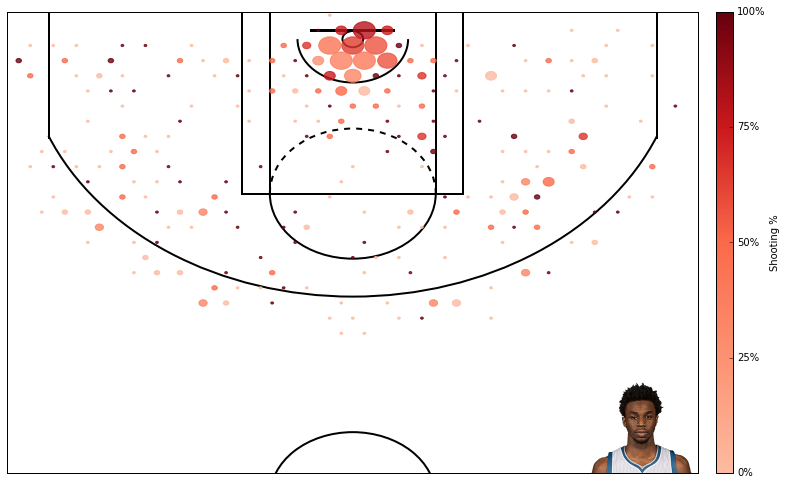

In [8]:
PlayerID = '203952' #andrew wiggins
shot_df = aqcuire_shootingData(PlayerID,'2015-16')
ax = shooting_plot(shot_df, plot_size=(12,8));

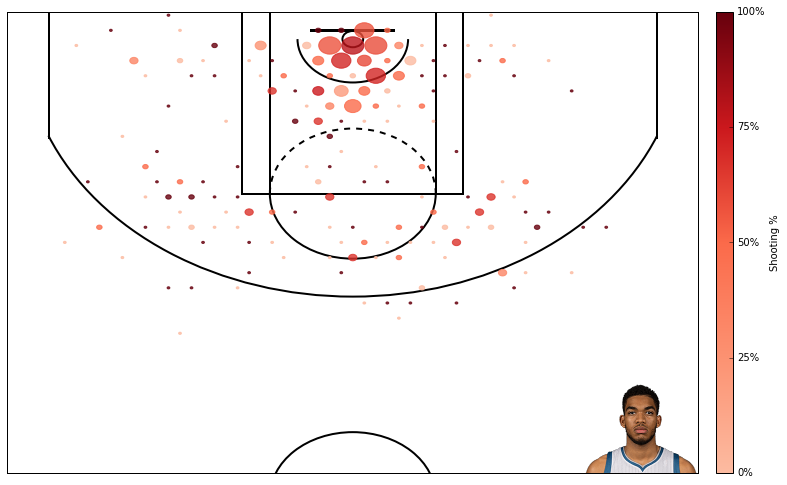

In [9]:
PlayerID = '1626157' #karl anthony towns
shot_df = aqcuire_shootingData(PlayerID,'2015-16')
ax = shooting_plot(shot_df, plot_size=(12,8));

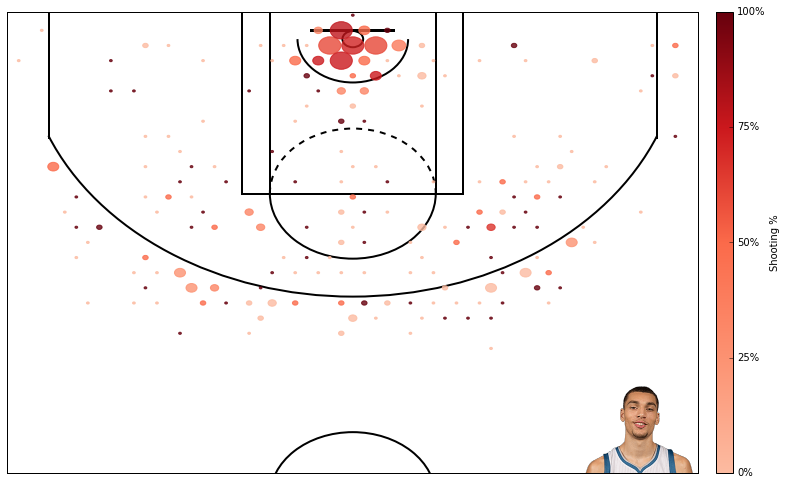

In [10]:
PlayerID = '203897' #zach lavine
shot_df = aqcuire_shootingData(PlayerID,'2015-16')
ax = shooting_plot(shot_df, plot_size=(12,8));


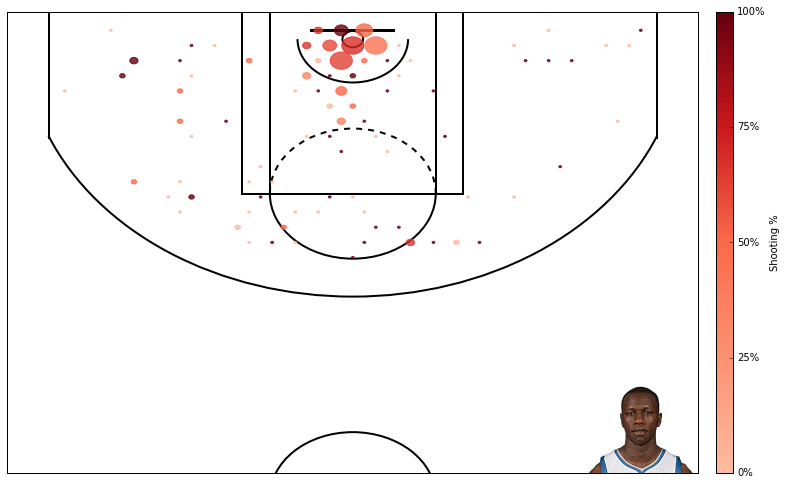

In [11]:
PlayerID = '203476' #gorgui deing
shot_df = aqcuire_shootingData(PlayerID,'2015-16')
ax = shooting_plot(shot_df, plot_size=(12,8));


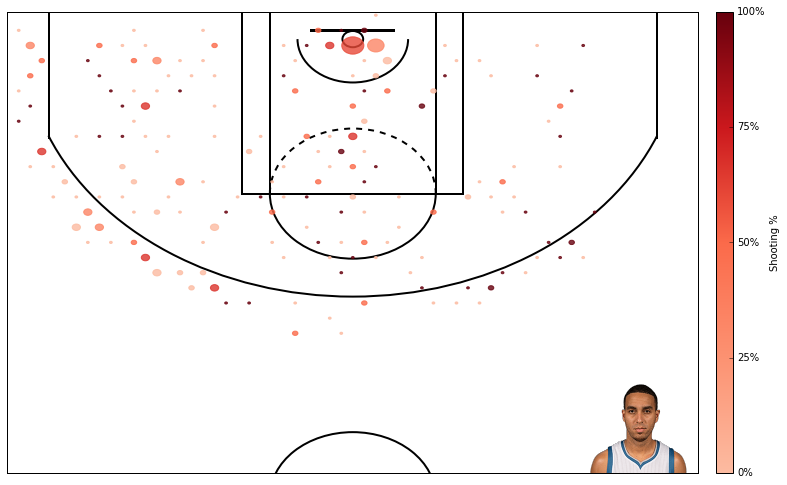

In [12]:
PlayerID = '2755' #kevin martin
shot_df = aqcuire_shootingData(PlayerID,'2015-16')
ax = shooting_plot(shot_df, plot_size=(12,8));

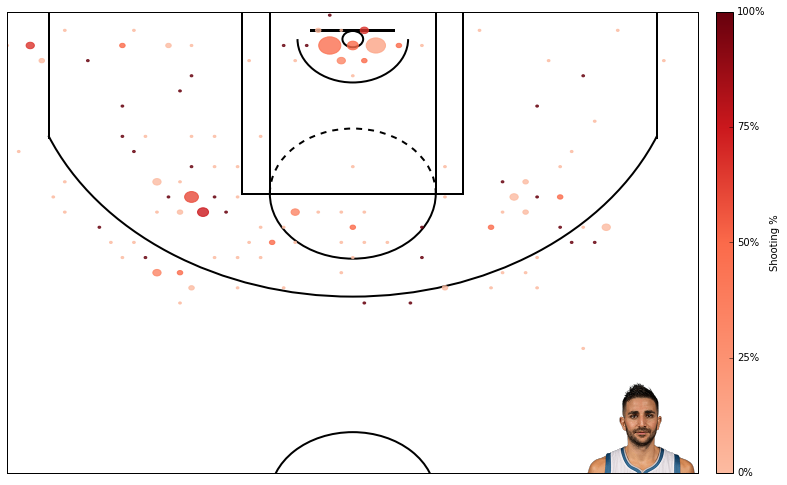

In [13]:
PlayerID = '201937' #ricky rubio
shot_df = aqcuire_shootingData(PlayerID,'2015-16')
ax = shooting_plot(shot_df, plot_size=(12,8));

One concern with my plots is the use of hexbin. It's a bit hacky. In particular, it does not account for the nonlinearity produced by the 3 point line (some hexbins include both long 2-pt shots and 3-pt shots). It would be nice to limit some bins to 3-pt shots, but I can't think of a way to do this without hardcoding the locations. One advantage with the hexbin method is I can easily change the number of bins. I'm not sure I could produce equivalent flexibility with a plot that bins 2-pt and 3-pt shots seperately. 

Another concern is my plots treat all shots as equal, which is not fair. Shooting 40% from the restricted area and behind the 3-pt line are very different. Austin Clemens accounts for this by plotting shooting percentage relative to league average. Maybe I'll implement something similar in the future.